<a href="https://colab.research.google.com/github/luizkrawiec/aed/blob/main/an%C3%A1lise_de_dados_luiz_krawiec_final_com_c%C3%B3digo_zip_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

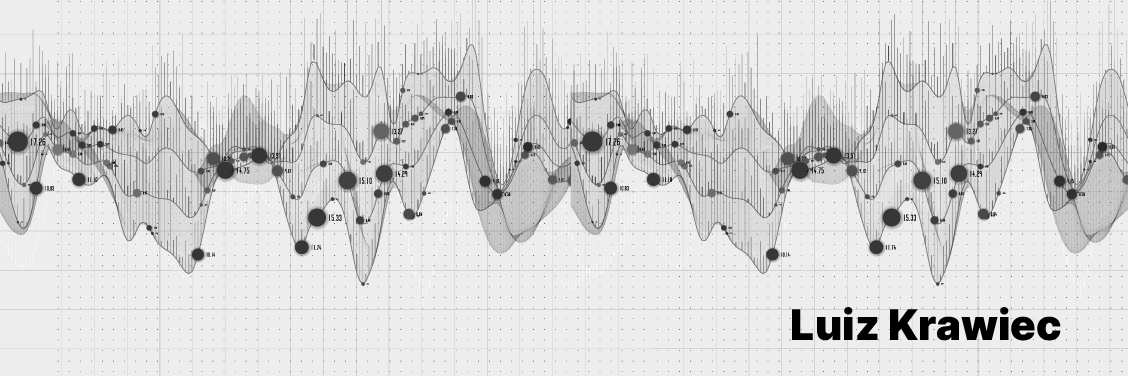

# **Análise Exploratória de Dados de Logística da Empresa Loggi**

## 1\. Contexto

**Análise Exploratória de dados da empresa Loggi.**

A Loggi, uma startup brasileira de tecnologia, é classificada como um unicórnio. Seu foco está na área de logística. A empresa iniciou suas operações em 2013, inicialmente dedicando-se à entrega de documentos, e expandiu seus serviços para o setor de e-commerce dois anos depois. A partir de 2017, a Loggi diversificou ainda mais suas operações, passando a atuar no segmento de entregas de alimentos

Pode-se classificar a Loggi como uma empresa de logística last mile, também conhecida como empresa de entrega de última milha, é uma empresa especializada em fornecer serviços de transporte e entrega de mercadorias diretamente aos consumidores finais ou empresas em sua localização final, geralmente em áreas urbanas ou suburbanas. A "última milha" se refere à última etapa da cadeia de suprimentos, na qual os produtos são entregues do centro de distribuição ou depósito para o destino final do cliente.
Essas empresas desempenham um papel crucial na entrega eficiente e oportuna de produtos aos clientes, especialmente em um ambiente de comércio eletrônico em rápido crescimento, onde a entrega rápida e confiável se tornou um fator-chave de sucesso nos negócios.

O Loggi Benchmark for Urban Deliveries (BUD) é um recurso disponível no GitHub (link) que oferece dados e códigos relacionados aos desafios comuns enfrentados por empresas de logística. Ele aborda questões como a otimização de rotas de entrega e a alocação eficiente de entregas em veículos com capacidade limitada. Esses dados são derivados de fontes públicas, incluindo o IBGE e o IPEA, e refletem os desafios diários que a startup Loggi enfrenta, particularmente em termos de sua expansão e dimensionamento contínuos.

e do próprio repositório do github da Loggi são apresentadas algumas tarefas (tasks).

- Task 1 - Last-Mile Capacitated Vehicle Routing Problem
This first task is a classic Capacitated Vehicle Routing Problem (CVRP) with minimizing travel distance as objetive. Although solving such large CVRPs with complete information is often impractical, these solutions are good targets for Task 2.

- Task 2 - Last-Mile Incremental Capacitated Vehicle Routing Problem
This is considered a particular case of Stochastic and Dynamic Capacitated Vehicle Routing Problems (SD-CVRP). The objetive is to sort deliveries into routes one by one as they arrive. You may use only historical information and the previously routed deliveries from the same instance. No recombination is allowed after assignment.
From an operations point of view, this solution class is a lot more powerful as it doesn't require full information before start routing. Instead, hub operators can route deliveries as they arrive.

- Task 3 - End-to-end last-mile problem
This is an extension of the task 1.2, but without fixed dispatch locations. Therefore, locations and allocation of requests to dispatch locations is considered part of the solution, but should be the same accross multiple instances. This can be considered an end-to-end optimization of last-mile delivery operations.

Baseado nessas tarefas vamos explorar os dados que a loggi nos disponibiliza.


## 2\. Pacotes e bibliotecas

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import geopy
from geopy.geocoders import Nominatim
import geopandas
from geopy.extra.rate_limiter import RateLimiter

!pip3 install geopandas;



## 3\. Exploração de dados

  O dado bruto disponibilizado pela empresa Loggi compreende um arquivo `JSON` que inclui uma lista de ocorrências de entregas, onde cada ocorrência representa um conjunto de entregas designadas aos veículos associados ao centro de distribuição regional. Um exemplo ilustrativo é o seguinte:

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


Onde:

 - **name**: Uma `string` contendo o nome exclusivo da instância.
 - **region**: Uma `string` contendo o nome exclusivo da região do hub.
 - **origin**: Um dicionário `dict` que inclui a latitude e a longitude da região do hub.
 - **vehicle_capacity**:  Um número inteiro `int` representando a soma da capacidade de carga dos veículos do hub.
 - **deliveries**: Uma lista `list` de dicionários `dict`que descrevem as entregas a serem realizadas.

Sendo que:

 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

Para iniciar a análise, começamos por processar os dados brutos e construímos o DataFrame Pandas deliveries_df por meio de operações como aplanamento (flatten) e expansão (explode) de colunas:

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

 - **Coluna**: origin

Podemos observar que a coluna `origin` contém dados aninhados na estrutura JSON. Vamos realizar uma normalização nessa coluna utilizando uma operação chamada `flatten` ou `achatamento`, que converterá cada chave do `JSON` em uma nova coluna:

 - **Coluna**: deliveries

Já a coluna `deliveries` contém uma lista de dados aninhados na estrutura do `JSON`. Vamos normalizar essa coluna utilizando uma operação chamada `explode`, que transformará cada elemento da lista em uma linha. Posteriormente, realizaremos o `achatamento` dos resultados em colunas separadas.

## 4\. Manipulação

In [ ]:
# dado bruto em um dict

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# dado bruto no pandas

deliveries_df = pd.DataFrame(data)

# coluna origin

hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# coluna deliveries

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [ ]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


Podemos verificar quais colunas possuem dados faltantes.

In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

### **4.1 Enriquecimento**

 **4.2 Geodificação reversa**

A `geocodificação` é o procedimento que converte informações de localização, como endereços ou nomes de lugares, em suas coordenadas geográficas correspondentes, ou seja, latitude e longitude. Por outro lado, a `geocodificação reversa` realiza o processo inverso, convertendo coordenadas geográficas de um local em suas descrições textuais correspondentes.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [ ]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [ ]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


 - **Geocodificação reversa da entrega**

Embora o hub contenha `apenas 3 geolocalizações distintas`, o número total de entregas são de `636.149`. Isso significa que, se considerarmos a limitação de uma consulta por segundo no servidor do Nominatim, levaria aproximadamente 7 dias para consultar todas as entregas. No entanto, para cargas pesadas como essa, o software oferece a opção de uma instalação local (na sua própria máquina), que pode ser usada sem nenhuma restrição, o que tornaria inviável a resolução do exercício, para contornar essa situação foi disponibilizado um arquivo CSV para continuar o exercício.

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


## **5\. Qualidade**

Agora podemos ver  a consistência dos dados após a manipulação como podemos ver o  `schema`, não existem valores faltantes.

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [ ]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [ ]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

## 6\. Visualização

 - **Mapa das Entregas**

Para criar a visualização, vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`.E com isso uma nova coluna será criada chamada `geometry`.

O pacote Python utilzado será o GeopPandas  para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal, segmentados pela região dos **hubs**. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

 - **Mapa do Distrito Federal**

o IBGE disponibilza através do seguinte  dados do mapa pelo seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) e  com esse link vamos criar  o DataFrame `mapa`. Reparem  na coluna `geometry`.

In [ ]:
'''
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

'''

'\n!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip\n!unzip -q distrito-federal.zip -d ./maps\n!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp\n!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx\n\n'

In [ ]:
from google.colab import files

# Faça o upload do arquivo ZIP da sua máquina
uploaded = files.upload()


Saving distrito_federal.zip to distrito_federal.zip


In [ ]:
# Substitua 'seu_arquivo.zip' pelo nome do arquivo ZIP que você fez o upload
zip_filename = 'distrito_federal.zip'

# Descompacte o arquivo ZIP
import zipfile

extraction_path = './maps/'

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Execute as cópias dos arquivos
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx


 - **Mapa dos Hubs**

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Vamos criar o DataFrame `geo_hub_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


 - **Mapa das Entregas**

Vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


 - **Visualização**

<ipython-input-33-44de6b1fad48>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


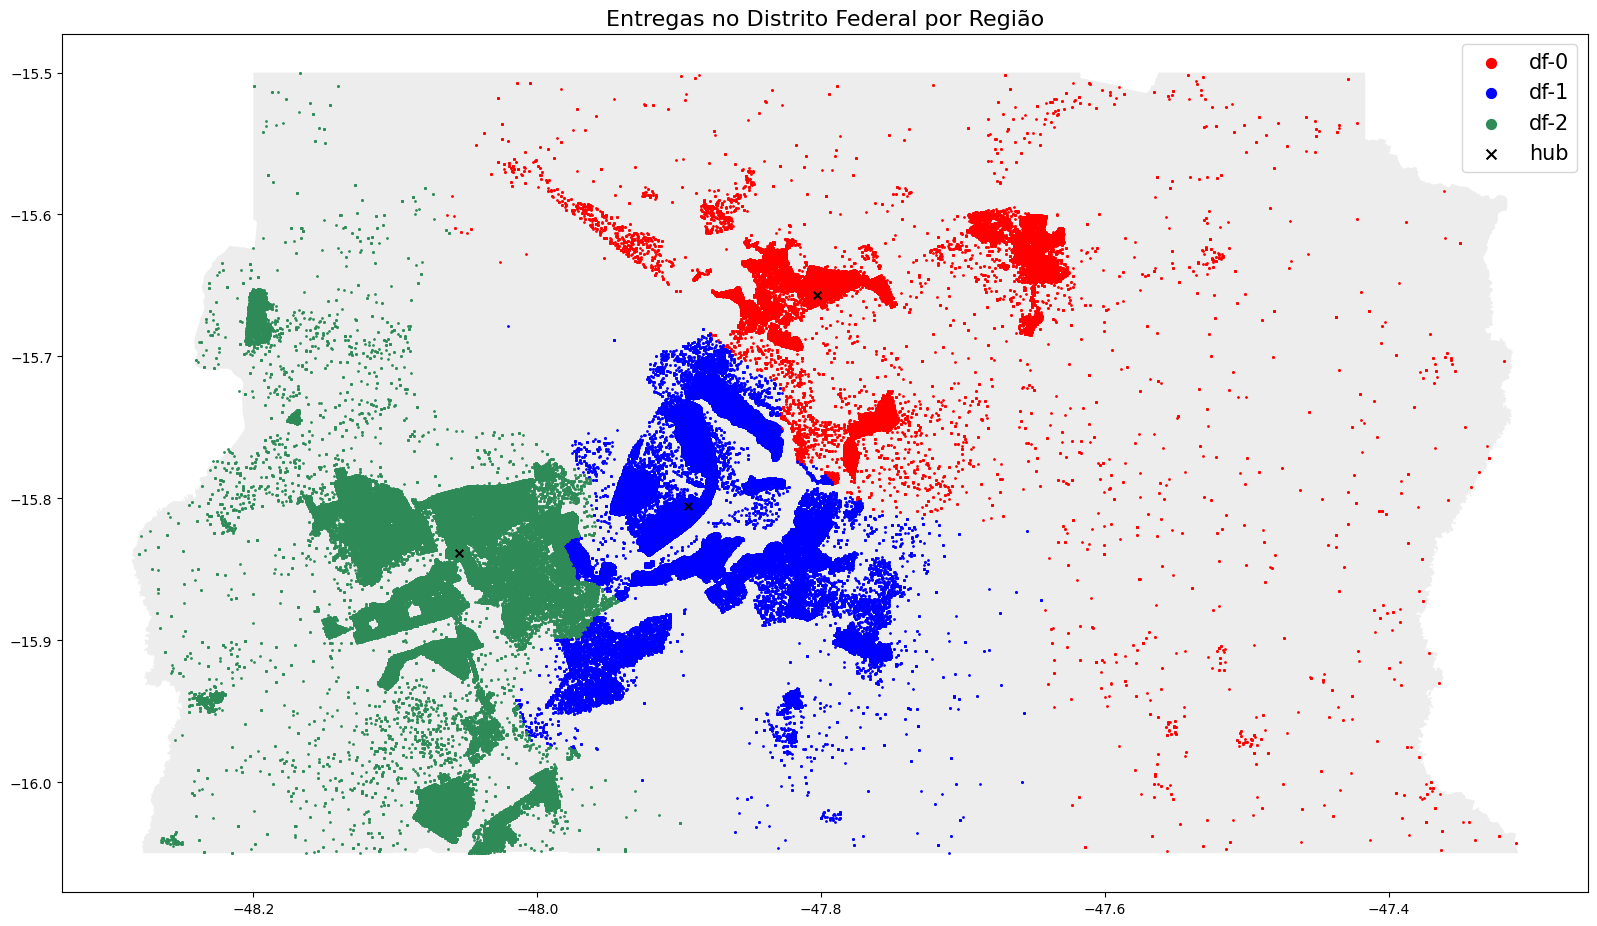

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

In [ ]:
# Filtrar as linhas onde 'region' é igual a 'df-0'
df_df0 = deliveries_df[deliveries_df['region'] == 'df-0']

# Resetar o índice do novo DataFrame, se necessário
df_df0.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
df_df0.head()


,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3,-47.754844,-15.651816,Itapoã,Del Lago II
1,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,4,-47.757320,-15.648223,Itapoã,Fazendinha
2,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,5,-47.756113,-15.652011,Itapoã,Del Lago II
3,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3,-47.758499,-15.653910,Itapoã,Condomínio Mansões Entrelagos
4,cvrp-0-df-7,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3,-47.755965,-15.653289,Itapoã,Condomínio Mansões Entrelagos


<ipython-input-35-a1cb7f508bd6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_df0['distance_hub_delivery'] = distances_hub_delivery


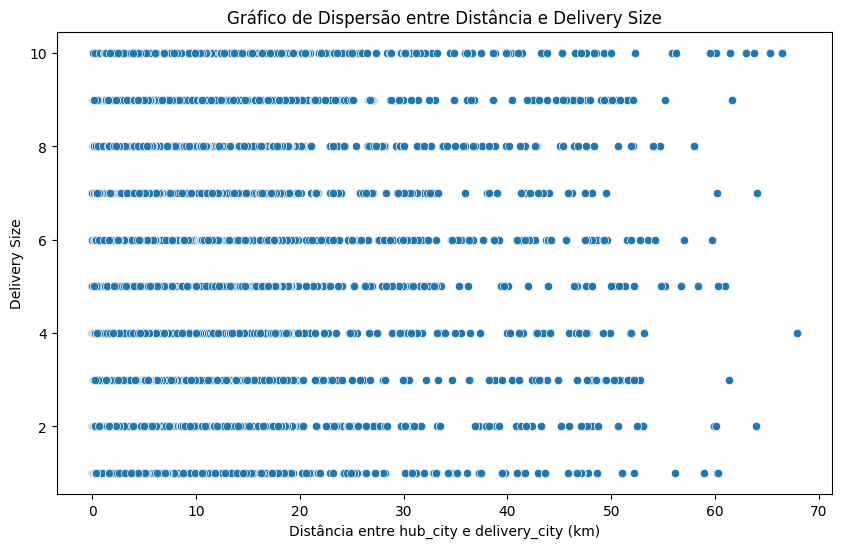

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Calcular a distância entre 'hub_city' e 'delivery_city' para cada linha
distances_hub_delivery = []

for index, row in df_df0.iterrows():
    hub_coords = (row['hub_lat'], row['hub_lng'])
    delivery_coords = (row['delivery_lat'], row['delivery_lng'])
    distance = geodesic(hub_coords, delivery_coords).km
    distances_hub_delivery.append(distance)

# Adicionar a coluna de distâncias ao DataFrame
df_df0['distance_hub_delivery'] = distances_hub_delivery

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_hub_delivery', y='delivery_size', data=df_df0)
plt.xlabel('Distância entre hub_city e delivery_city (km)')
plt.ylabel('Delivery Size')
plt.title('Gráfico de Dispersão entre Distância e Delivery Size')
plt.show()


In [ ]:
# Filtrar as linhas onde 'region' é igual a 'df-0'
df_df1 = deliveries_df[deliveries_df['region'] == 'df-1']

# Resetar o índice do novo DataFrame, se necessário
df_df1.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
df_df1.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,1,-47.927859,-15.831986,Planaltina,Setor de Áreas Especiais Norte
1,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,3,-47.922794,-15.828594,Planaltina,Vila Nossa Senhora de Fátima
2,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,1,-47.921504,-15.827437,Planaltina,Vila Nossa Senhora de Fátima
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,9,-47.926989,-15.830776,Planaltina,Setor Residencial Leste - Buritis I
4,cvrp-1-df-71,df-1,-47.893662,-15.805118,Brasília,Asa Sul,180,7,-47.922002,-15.826991,Planaltina,Setor Residencial Leste - Buritis II


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Calcular a distância entre 'hub_city' e 'delivery_city' para cada linha
distances_hub_delivery = []

for index, row in df_df1.iterrows():
    hub_coords = (row['hub_lat'], row['hub_lng'])
    delivery_coords = (row['delivery_lat'], row['delivery_lng'])
    distance = geodesic(hub_coords, delivery_coords).km
    distances_hub_delivery.append(distance)

# Adicionar a coluna de distâncias ao DataFrame
df_df1['distance_hub_delivery'] = distances_hub_delivery

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_hub_delivery', y='delivery_size', data=df_df1)
plt.xlabel('Distância entre hub_city e delivery_city (km)')
plt.ylabel('Delivery Size')
plt.title('Gráfico de Dispersão entre Distância e Delivery Size')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
# Filtrar as linhas onde 'region' é igual a 'df-0'
df_df2 = deliveries_df[deliveries_df['region'] == 'df-2']

# Resetar o índice do novo DataFrame, se necessário
df_df2.reset_index(drop=True, inplace=True)

# Exibir as primeiras linhas do novo DataFrame
df_df2.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Calcular a distância entre 'hub_city' e 'delivery_city' para cada linha
distances_hub_delivery = []

for index, row in df_df2.iterrows():
    hub_coords = (row['hub_lat'], row['hub_lng'])
    delivery_coords = (row['delivery_lat'], row['delivery_lng'])
    distance = geodesic(hub_coords, delivery_coords).km
    distances_hub_delivery.append(distance)

# Adicionar a coluna de distâncias ao DataFrame
df_df2['distance_hub_delivery'] = distances_hub_delivery

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_hub_delivery', y='delivery_size', data=df_df2)
plt.xlabel('Distância entre hub_city e delivery_city (km)')
plt.ylabel('Delivery Size')
plt.title('Gráfico de Dispersão entre Distância e Delivery Size')
plt.show()

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

In [ ]:
import seaborn as sns

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

 - **Insights**:

- As entregas estão devidamente atribuídas aos seus respectivos hubs.

- Os hubs nas regiões 0 e 2 realizam entregas em locais afastados do centro e entre si, o que pode resultar em tempos de entrega mais longos e custos mais elevados

- A concentração das entregas é significativamente maior nos hubs das regiões 1 e 2, enquanto é relativamente baixa na região 0. No entanto, a capacidade dos veículos é uniforme para todos os hubs, o que sugere a possibilidade de realocar os veículos para atender às áreas de maior demanda de tráfego.

- Podemos notar através dos gráficos de dispersão que no df-0 percorre a maior distância e que os veículos fazem a rota mais distantes com maior número de carga possível, mas com menos entregas que na região df-1

- Refrente a questão da geodecoficação reversa, para cumprir com as diretrizes da LGPD, é essencial que os desenvolvedores utilizem a Nominatim de maneira responsável e garantam que os dados de endereço e geolocalização não sejam utilizados de forma indevida ou compartilhados sem o consentimento adequado.